# Problem 4: Extended Kalman Filter for SLAM

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

np.random.seed(123456)

## Simulation Setup

In [29]:
# Timesteps.
dt = 0.1
tf = 15
time = np.arange(0, tf+dt, dt)

# Ground-truth landmark positions.
xm = np.array([0, 0, 2, 8, 8, 2, 10, 10])
mr = len(xm) % 2

## Dynamics and Measurement Equations

In [30]:
def dynamics_model(
    x: np.ndarray,
    v: float,
    omega: float,
) -> np.ndarray:
    """Kalman Filter dynamics model.

    NOTE: This dynamics model includes dynamics of both robot and landmarks.

    Args:
        x (np.ndarray): Robot + Landmark concatenated state.
        v (float): Linear velocity command.
        omega (float): Angular velocity command.

    Returns:
        np.ndarray: Next robot state.
    """
    px = x[0]
    py = x[1]
    th = x[2]
    m = x[3::]

    f_robot = np.array([px + dt * v * np.cos(th),
                        py + dt * v * np.sin(th),
                        th + dt * omega])

    return np.hstack((f_robot, m))

def measurement_model(
    x: np.ndarray,
) -> np.ndarray:
    """Kalman Filter measurement model.

    NOTE: This measurement model corresponds to Eq. (4) in the
          homework PDF document.

    Args:
        x (np.ndarray): Robot + Landmark concatenated state.

    Returns:
        np.ndarray: Expected measurement.
    """
    px = x[0]
    py = x[1]
    th = x[2]
    m = x[3::]

    rot_mtx = np.array([[np.cos(th), np.sin(th)],
                        [-np.sin(th), np.cos(th)]])

    rot_mtx_tile = np.kron(np.eye(4, dtype=int),rot_mtx)
    robot_position_tile = np.tile(np.array([px, py]), (4,))
    return rot_mtx_tile @ (m - robot_position_tile)

def getG(
    x: np.ndarray,
    v: float,
    omega: float,
):
    """Computes the Jacobian of the dynamics model with respect
    to the robot state and input commands.

    Args:
        x (np.ndarray): Robot + Landmark concatenated state.
        v (float): Linear velocity command.
        omega (float): Angular velocity command.

    Returns:
        G (np.ndarray): Jacobian of the dynamics model.
    """
    ####################### Code starts here #######################
    xr = x[:3]
    xm = x[3:]
    
    theta = xr[2]
    Gr = np.eye(3)
    Gr[0,2] = -v*np.sin(theta)*dt
    Gr[1,2] = v*np.cos(theta)*dt

    G = np.eye(x.shape[0])
    G[:3,:3] = Gr


    ####################### Code ends here #######################
    return G


def getH(
    x: np.ndarray,
) -> np.ndarray:
    """Computes the Jacobian of the measurement model with respect
    to the robot state and the landmark positions.

    Args:
        x (np.ndarray): Robot + Landmark concatenated state.
    Returns:
        H (np.ndarray): Jacobian of the measurement model.
    """
    ####################### Code starts here #######################
    num_landmarks = 4
    num_states = 3

    xr = x[:num_states]
    xm = x[num_states:]
    
    H = np.zeros((8,11))

    def get_2rows(xmi,xr):
        """
        xmi: (2,1) array for (xmi,ymi)
        xr: x,y,theta
        """
        x,y,theta = xr.flatten()
        xmi,ymi = xmi.flatten() # Flattening to make it 2, even if it is (2,1)

        rows = np.array([[-np.cos(theta),-np.sin(theta), -np.sin(theta)*(xmi-x)+np.cos(theta)*(ymi-y)],
                         [np.sin(theta), -np.cos(theta), -np.cos(theta)*(xmi-x)-np.sin(theta)*(ymi-y)]])
        
        return rows
    
    theta = xr[2]
    H_theta = np.array([[np.cos(theta),np.sin(theta)],
                        [-np.sin(theta),np.cos(theta)]])
    
    for i in range(num_landmarks):
        xmi = xm[2*i:2*i+2]
        H[2*i:2*i+2,:num_states] = get_2rows(xmi,xr)

        H[2*i:2*i+2,2*i+num_states:2*i+num_states+2] = H_theta

    ####################### Code ends here #######################
    return H

## Extended Kalman Filter Setup

In [31]:
# Ground-truth states (simulated).
x = np.zeros((11, len(time)))
x[0:3, 0] = np.array([1, 1, 0])
x[3::, 0] = np.array([0, 0, 2, 8, 8, 2, 10, 10])

# Estimated states (Kalman Filter).
mu_ekf = np.zeros((11, len(time)))
cov_ekf = [np.eye(11) for _ in range(len(time))]

# Initial state and state covariance estimate.
init_mu_std = 0.1
mu_ekf[:, 0] = x[:,0] + np.random.multivariate_normal(np.zeros((11,)), init_mu_std*np.eye(11))

# Process and observation noise.
Q = (dt**2 * 0.1) * np.eye(11)
Q[3::, 3::] = np.zeros((8,8))
R = 0.25 * np.eye(8)

# Extended Kalman Filter Implementation

In [32]:
for i in range(1, len(time)):
    ### Simulation.

    # True robot commands
    v = 1
    omega = np.sin(time[i])

    # True robot dynamics
    w_noise = np.random.multivariate_normal(np.zeros((11,)), Q)
    x[:, i] = dynamics_model(x[:, i-1], v, omega) + w_noise

    # True received measurement
    v_noise = np.random.multivariate_normal(np.zeros((8,)), R)
    y = measurement_model(x[:, i]) + v_noise

    ### Estimation.

    ####################### Code starts here #######################
    # NOTE: Implement Extended Kalman Filter Predict and Update steps.
    # Write resulting means to mu_ekf.
    # Write resulting covariances to cov_ekf.

    # EKF Prediction
    # Hint: Find current G (Jacobian of the state dynamics model)

    # EKF Update
    # Hint: Find current H (Jacobian of the measurement model)
    # Prediction
    mu_prev = mu_ekf[:,i-1]
    G = getG(mu_prev,v,omega)

    mu_bar_t = dynamics_model(mu_prev,v,omega) # Shape of 8,1
    assert mu_bar_t.shape == (11,1) or mu_bar_t.shape == (11,)
    sigma_bar_t = G@cov_ekf[i-1]@G.T + Q
    assert sigma_bar_t.shape == (11,11)

    # Correction Step
    H = getH(mu_bar_t)
    assert H.shape == (8,11)


    Kt = sigma_bar_t@H.T@np.linalg.inv(H@sigma_bar_t@H.T + R)
    assert Kt.shape == (11,8)

    z_measurement_model = measurement_model(mu_bar_t)
    # print(z_measurement_model.shape)
    
    mu_t = mu_bar_t + Kt@(y-z_measurement_model)
    # print(mu_t.shape)
    sigma_t = (np.eye(11) - Kt@H)@sigma_bar_t

    # # Saving the Values
    mu_ekf[:,i] = mu_t
    cov_ekf[i] = sigma_t;

    ####################### Code ends here #######################

## Plot Results

In [34]:
def plot_error_ellipse(ax, mean, cov):
    # Calculate the error ellipse parameters
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))

    # Compute the radius of the ellipse to correspond to the desired confidence level
    chi2_val = 2.4477  # Corresponds to 95% conf. interval
    width, height = 2 * chi2_val * np.sqrt(eigenvalues)

    # Draw the ellipse
    ellipse = patches.Ellipse(mean, width, height, angle, edgecolor='red', fc='None', lw=2)
    ax.add_patch(ellipse)

### Plot Mean Estimates of Robot Pose Trajectory

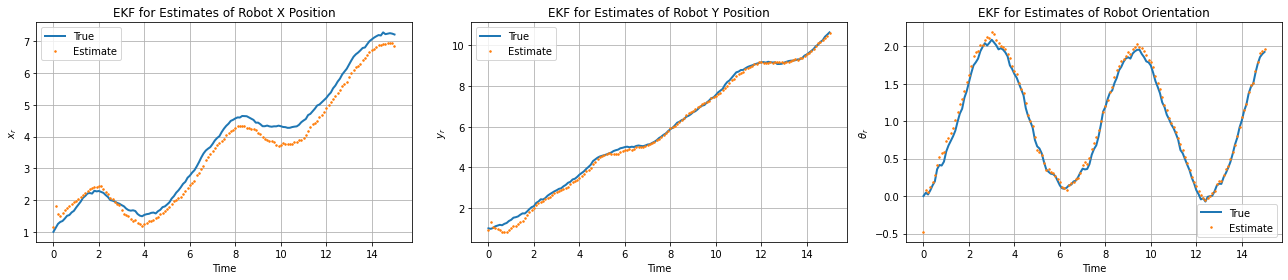

In [35]:
plt.figure(figsize=(18, 4))

# Subplot for px
plt.subplot(131)
plt.title('EKF for Estimates of Robot X Position')
plt.plot(time, x[0, :], linewidth=2, label='True')
plt.plot(time, mu_ekf[0, :], '.', markersize=3, label='Estimate')
plt.xlabel('Time')
plt.ylabel(r'$x_r$')
plt.legend()
plt.grid(True)

# Subplot for py
plt.subplot(132)
plt.title('EKF for Estimates of Robot Y Position')
plt.plot(time, x[1, :], linewidth=2, label='True')
plt.plot(time, mu_ekf[1, :], '.', markersize=3, label='Estimate')
plt.xlabel('Time')
plt.ylabel(r'$y_r$')
plt.legend()
plt.grid(True)

# Subplot for theta
plt.subplot(133)
plt.title('EKF for Estimates of Robot Orientation')
plt.plot(time, x[2, :], linewidth=2, label='True')
plt.plot(time, mu_ekf[2, :], '.', markersize=3, label='Estimate')
plt.xlabel('Time')
plt.ylabel(r'$\theta_r$')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Plot Mean Estimates of 2D Landmark Positions

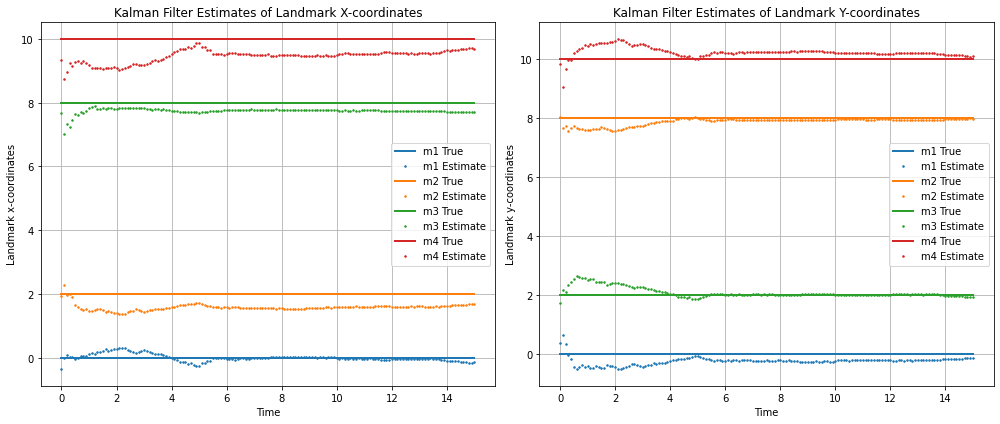

In [36]:
plt.figure(figsize=(14, 6))

# Subplot for x positions.
plt.subplot(121)
plt.title('Kalman Filter Estimates of Landmark X-coordinates')
plt.plot(time, x[3, :], linewidth=2, label='m1 True', color='C0')
plt.plot(time, mu_ekf[3, :], '.', markersize=3, label='m1 Estimate', color='C0')
plt.plot(time, x[5, :], linewidth=2, label='m2 True', color='C1')
plt.plot(time, mu_ekf[5, :], '.', markersize=3, label='m2 Estimate', color='C1')
plt.plot(time, x[7, :], linewidth=2, label='m3 True', color='C2')
plt.plot(time, mu_ekf[7, :], '.', markersize=3, label='m3 Estimate', color='C2')
plt.plot(time, x[9, :], linewidth=2, label='m4 True', color='C3')
plt.plot(time, mu_ekf[9, :], '.', markersize=3, label='m4 Estimate', color='C3')
plt.xlabel('Time')
plt.ylabel('Landmark x-coordinates')
plt.legend()
plt.grid(True)

# Subplot for y positions.
plt.subplot(122)
plt.title('Kalman Filter Estimates of Landmark Y-coordinates')
plt.plot(time, x[4, :], linewidth=2, label='m1 True', color='C0')
plt.plot(time, mu_ekf[4, :], '.', markersize=3, label='m1 Estimate', color='C0')
plt.plot(time, x[6, :], linewidth=2, label='m2 True', color='C1')
plt.plot(time, mu_ekf[6, :], '.', markersize=3, label='m2 Estimate', color='C1')
plt.plot(time, x[8, :], linewidth=2, label='m3 True', color='C2')
plt.plot(time, mu_ekf[8, :], '.', markersize=3, label='m3 Estimate', color='C2')
plt.plot(time, x[10, :], linewidth=2, label='m4 True', color='C3')
plt.plot(time, mu_ekf[10, :], '.', markersize=3, label='m4 Estimate', color='C3')
plt.xlabel('Time')
plt.ylabel('Landmark y-coordinates')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Plot Error Ellipses Along Trajectory and Landmarks

/var/folders/pw/pb93h1ws5dx02zs9x_45hk4w0000gn/T/ipykernel_20550/3806365674.py:13: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = patches.Ellipse(mean, width, height, angle, edgecolor='red', fc='None', lw=2)


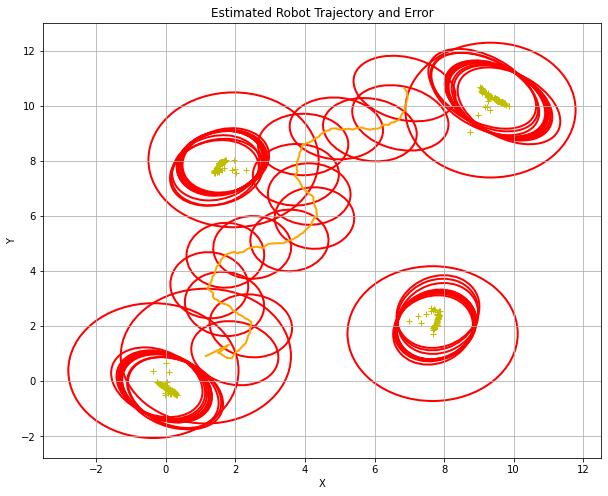

In [37]:
plt.figure(figsize=(10, 8))
plt.title('Estimated Robot Trajectory and Error')
plt.plot(mu_ekf[0, :], mu_ekf[1, :], color='orange', linewidth=2)
plt.plot(mu_ekf[3, :], mu_ekf[4, :], 'y+')
plt.plot(mu_ekf[5, :], mu_ekf[6, :], 'y+')
plt.plot(mu_ekf[7, :], mu_ekf[8, :], 'y+')
plt.plot(mu_ekf[9, :], mu_ekf[10, :], 'y+')
for i in range(0, len(time), 10):
    plot_error_ellipse(plt.gca(), mu_ekf[:2, i], cov_ekf[i][:2, :2])
    plot_error_ellipse(plt.gca(), mu_ekf[3:5, i], cov_ekf[i][3:5, 3:5])
    plot_error_ellipse(plt.gca(), mu_ekf[5:7, i], cov_ekf[i][5:7, 5:7])
    plot_error_ellipse(plt.gca(), mu_ekf[7:9, i], cov_ekf[i][7:9, 7:9])
    plot_error_ellipse(plt.gca(), mu_ekf[9:11, i], cov_ekf[i][9:11, 9:11])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

### Plot Robot Trajectory in X-Y Space

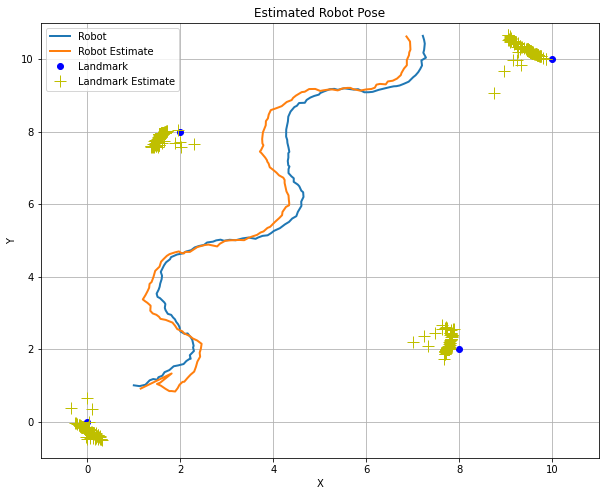

In [38]:
plt.figure(figsize=(10, 8))
plt.title('Estimated Robot Pose')
plt.plot(x[0, :], x[1, :], linewidth=2, label='Robot')
plt.plot(mu_ekf[0, :], mu_ekf[1, :], linewidth=2, label='Robot Estimate')
plt.plot(xm.reshape((4,2))[:, 0], xm.reshape((4,2))[:, 1], 'b.', markersize=12, label='Landmark')
plt.plot(mu_ekf[3, :], mu_ekf[4, :], 'y+', markersize=12, label='Landmark Estimate')
plt.plot(mu_ekf[5, :], mu_ekf[6, :], 'y+', markersize=12)
plt.plot(mu_ekf[7, :], mu_ekf[8, :], 'y+', markersize=12)
plt.plot(mu_ekf[9, :], mu_ekf[10, :], 'y+', markersize=12)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.xlim([-1, 11])
plt.ylim([-1, 11])
plt.grid(True)
plt.show()